# SNRateMetric

In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs') #path where to find the lsst util
from opsimUtils import *

from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from lsst.sims.maf.utils import m52snr, radec2pix

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from pylab import cm
import time
from itertools import groupby

#we use PSNID to classify the simulates observedlightcurve, thus we define paths to the SNANA directories
os.environ['SNANA_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNANA'
os.environ['SNDATA_ROOT']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNDATA_ROOT'
os.environ['LSST_DIR']='./util_snrmetric'
%matplotlib inline

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
surveyDuration = 1 
init = 1 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint+=' and proposalId > 1'  #indica a cosa sono riferiti i differenti proposalId

In [4]:
nside = 16
slicer = slicers.HealpixSlicer(nside=nside)
pixelarea = hp.nside2pixarea(nside,degrees=True)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [5]:
from SNclassification_metric import SNclassification_metric, template_lc, getDataMetric 

## Observer light curves from SN templates

We simulate the K-corrected templates' ligh curves within a given redshift range. 

List of the template SNe used for the simulation in Table 3 [Cappellaro et al. 2015](https://arxiv.org/pdf/1509.04496.pdf)

The dictionary for the tempates is defined by the SN type and subtybe, moreover within each subtype it is indicated the rate of each group of templates for the subtype.

In [6]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [7]:
temp = template_lc(sn_group=sngroups ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

I'm reading the templates


In [8]:
obs_template['magobs'].keys()

dict_keys(['1990N', '1992A', '1994D', '2002bo', '1991T', '1999ee', '1991bg', '2000cx', '2002cx', '1999em', '2004et', '2009bw', '1999br', '1999gi', '2005cs', '1992H', '1993J', '2008ax', '1987A', '2010jl', '1998S', '1997cy', '2005gj', '2009jf', '2008D', '1994I', '2004aw', '2007gr', '1998bw', '2008es'])

We augumented the template dataset, simulating the light curves at different redshift. To take account of the effect of the distance on the lightcurve we applied the K-correction. We also consider the effect of the time dilation simulating light curves at different redshift. 

Here an example:

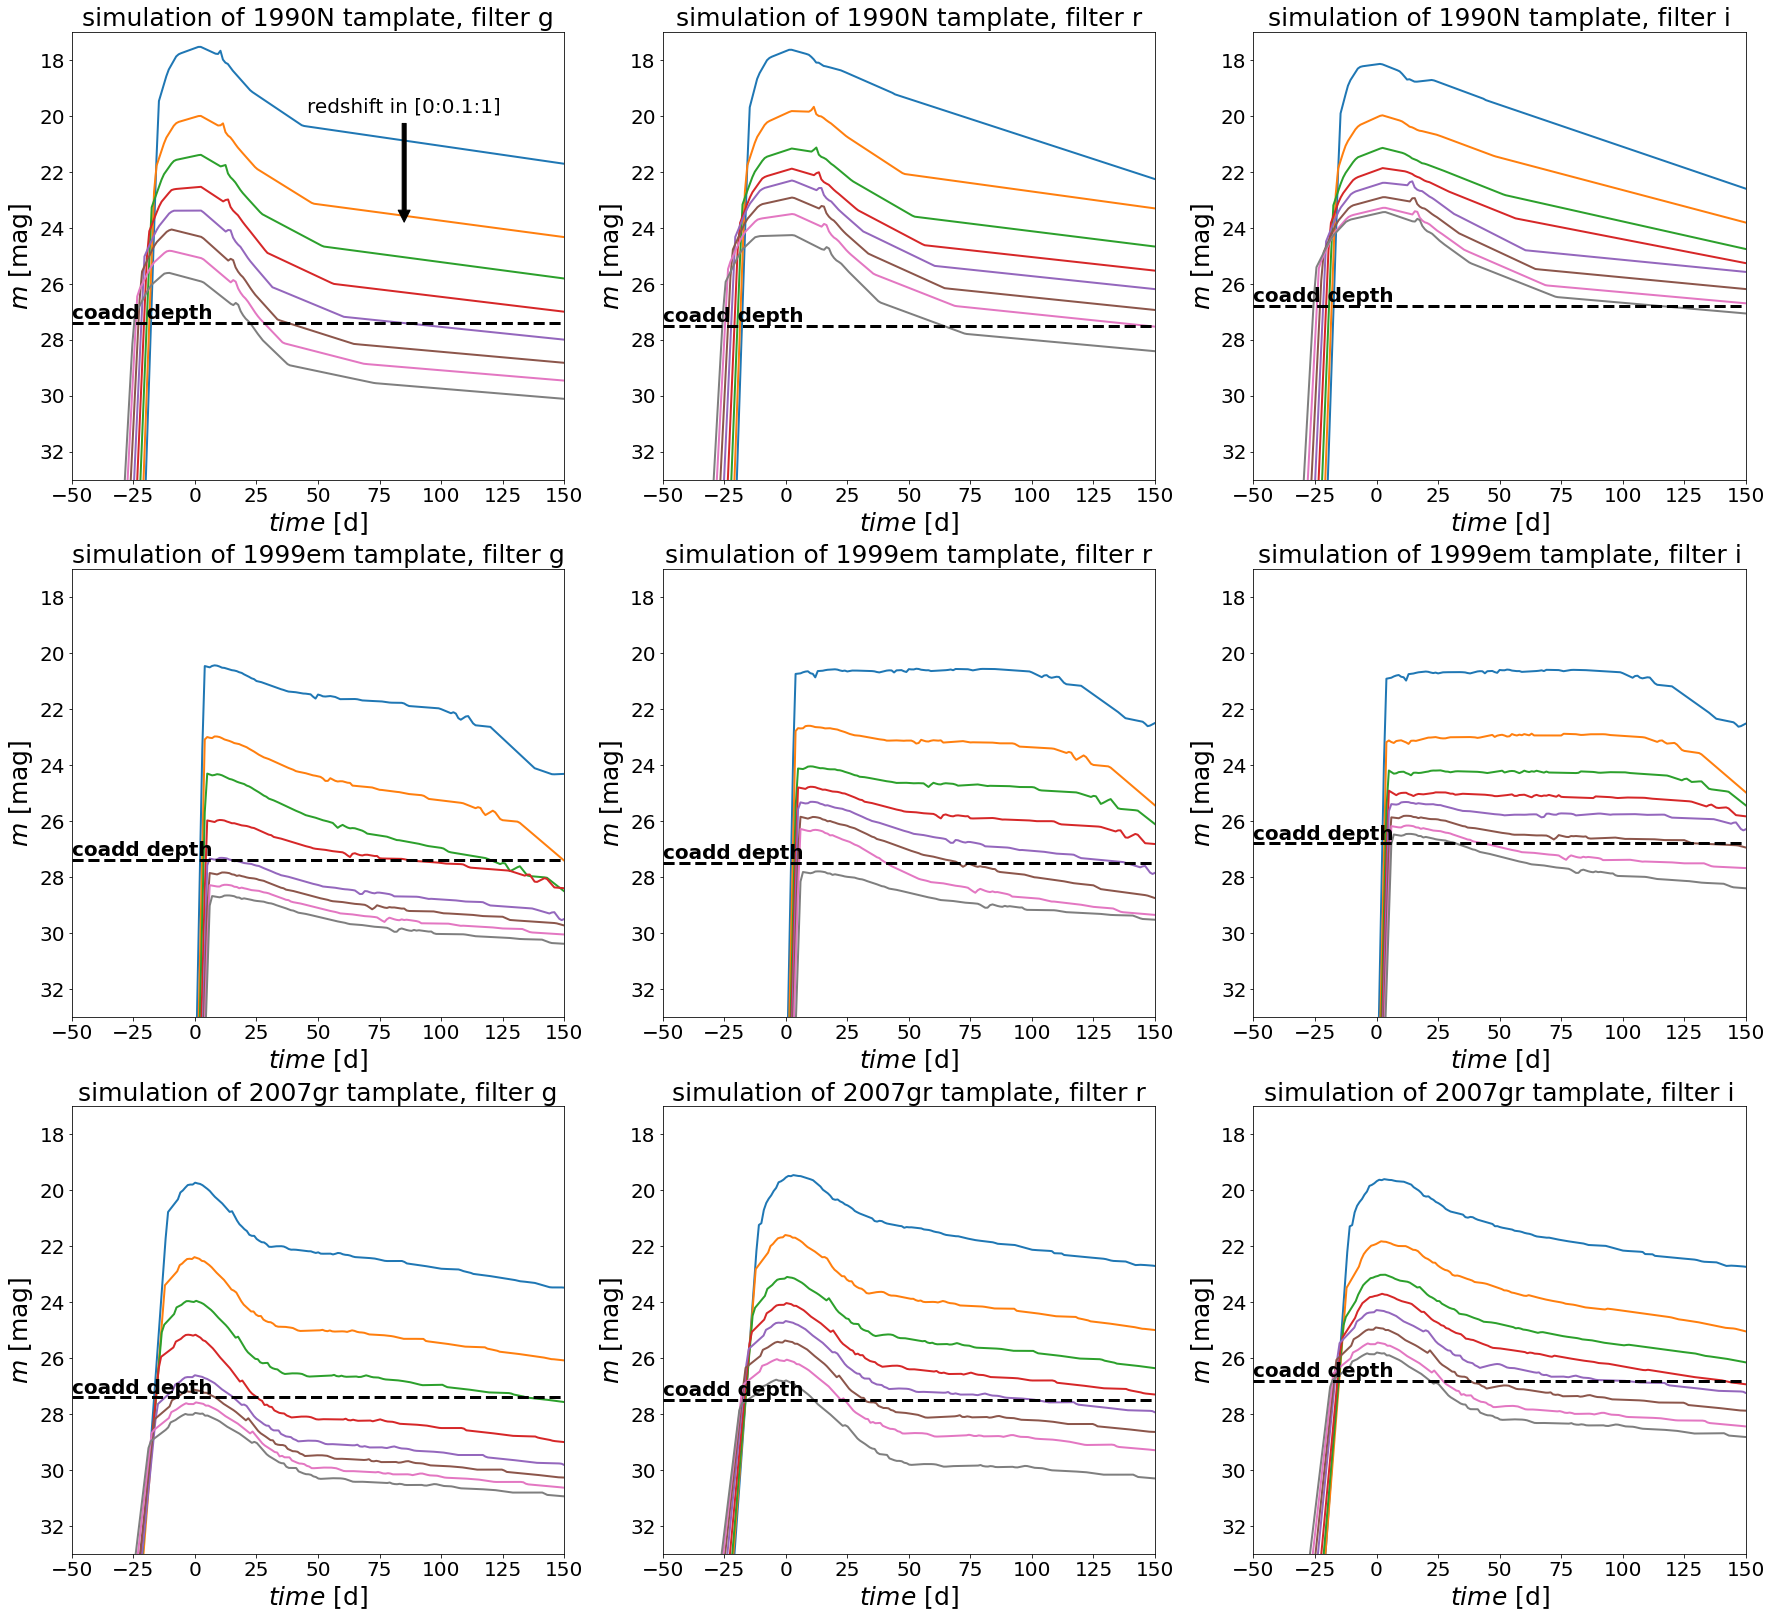

In [9]:
fig, axs = plt.subplots(3,3,figsize=(30,28))
for i, t in enumerate(['1990N','1999em','2007gr']):
    for j, f in enumerate(['g','r','i']):
        for z in obs_template['phobs'][t].keys():
            mag =obs_template['magobs'][t][z][f]
            ph = obs_template['phobs'][t][z][f]
            axs[i,j].plot(ph, mag,'-',lw=2)
        axs[i,j].invert_yaxis()
        if i==0 and j==0:
            axs[i,j].annotate('redshift in [0:0.1:1]',xy=(85, 24),xycoords='data',xytext=(85, 20), textcoords='data',fontsize=20,
                arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='center', verticalalignment='bottom')
        axs[i,j].set_ylim([33,17])
        axs[i,j].set_xlim([-50,150])
        axs[i,j].set_xlabel(r'$time$ [d]',fontsize=25)
        axs[i,j].set_ylabel(r'$m$ [mag]',fontsize=25)
        axs[i,j].set_title(r'simulation of {} tamplate, filter {}'.format(t,f),fontsize=25)
        axs[i,j].tick_params('both', labelsize=20)
        if f == 'g':
            px,py = [-50,150],[27.4,27.4]
        elif f =='r':
            px,py=[-50,150],[27.5,27.5]
        elif f=='i':
            px,py = [-50,150],[26.8,26.8]
        axs[i,j].plot(px,py, 'k--', lw=3)
        axs[i,j].annotate('coadd depth',xy=(px[0],py[0]),xycoords='data',fontsize=20, weight='bold',
               horizontalalignment='left', verticalalignment='bottom')

These templates are then used to simulate SN that explode during the survey. 

As an example we have constrained the survey to observe the Sky for 1 yr. We set an array of explosion epochs that space uniformly the year. 

In [10]:
expl_range=np.arange(0,365,10)
expl_range.size

37

(array([10., 10., 10.,  7.]),
 array([  0, 100, 200, 300, 365]),
 <BarContainer object of 4 artists>)

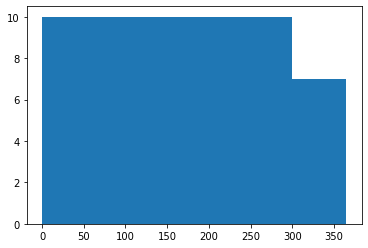

In [11]:
plt.hist(expl_range, np.array([0,100,200,300,365]))

Once we have associated an explosion epoch to the light curves, we compare interpolate the magnitude values at the LSST observed epochs. 

In [12]:
import glob

workpath = os.getcwd()
os.chdir(dbDir)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()

In [13]:
dblist_all[0]

'baseline_nexp1_v1.7_10yrs.db'

In [14]:
dbname = dblist_all[0]
opsdb = db.OpsimDatabase(dbDir+dbname)
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter','visitExposureTime','visitTime'])
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5  and proposalId > 1 for columns ['observationStartMJD', 'filter', 'fiveSigmaDepth', 'fieldDec', 'night', 'fieldRA', 'visitExposureTime', 'visitTime']
Found 5722 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [15]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True, )

In [16]:
df

,observationStartMJD,filter,fiveSigmaDepth,fieldDec,night,fieldRA,visitExposureTime,visitTime
0,60353.159656,i,23.789254,1.549694,500,150.353768,30.0,31.0
1,60372.110274,i,23.515029,2.642504,519,150.626169,30.0,31.0
2,60349.152259,r,23.492588,1.841210,496,150.553481,30.0,31.0
3,60349.152641,r,23.425698,1.841210,496,150.553481,30.0,31.0
4,60349.153023,r,23.427100,1.841210,496,150.553481,30.0,31.0
...,...,...,...,...,...,...,...,...
3867,60564.387244,r,24.348909,-47.553492,711,63.088917,30.0,31.0
3868,60564.387626,r,24.348639,-47.553492,711,63.088917,30.0,31.0
3869,60564.390787,r,24.438800,-47.553492,711,63.088917,30.0,31.0
3870,60564.391169,r,24.438509,-47.553492,711,63.088917,30.0,31.0


To properly coadd the visits in the same night we operate some edits on the dataframe:

In [17]:
keygroup = ['filter', 'night']

df.sort_values(by=keygroup, ascending=[
                 True, True], inplace=True)

coadd_df = df.groupby(keygroup).agg({'visitExposureTime': ['sum'],
                                       'visitTime': ['sum'],
                                       'observationStartMJD': ['mean'],
                                       'fieldRA': ['mean'],
                                       'fieldDec': ['mean'],
                                       'fiveSigmaDepth': ['mean']}).reset_index()

coadd_df.columns = ['filter','night', 'visitExposureTime','visitTime',
                    'observationStartMJD', 'fieldRA', 'fieldDec',
                    'fiveSigmaDepth']

coadd_df.loc[:, 'fiveSigmaDepth'] += 1.25 * \
    np.log10(coadd_df['visitTime']/30.)

coadd_df.sort_values(by=['filter', 'night'], ascending=[
                     True, True], inplace=True)

In [18]:
coadd_df

,filter,night,visitExposureTime,visitTime,observationStartMJD,fieldRA,fieldDec,fiveSigmaDepth
0,g,368,300.0,310.0,60221.112796,8.970756,-44.017869,25.871821
1,g,369,300.0,310.0,60222.178553,35.343329,-4.956245,26.052102
2,g,370,300.0,310.0,60223.180467,53.125671,-28.682874,25.771225
3,g,372,300.0,310.0,60225.194087,35.350342,-4.816874,25.856232
4,g,374,1200.0,1240.0,60227.228782,52.848954,-32.746803,26.529350
...,...,...,...,...,...,...,...,...
166,r,713,600.0,620.0,60566.343662,35.327134,-5.092714,25.859743
167,r,723,600.0,620.0,60576.157742,9.536181,-44.244882,26.202778
168,r,725,600.0,620.0,60578.240291,36.344466,-4.475056,25.752712
169,r,727,1200.0,1240.0,60580.256669,49.478615,-26.404207,26.344076


To check if there are any observation during the period we simulate the ligh curve on we create a mask. To show an example we need to fix a template (here 1990N) a redshift (here z =0.1) and an explosion time.

In [19]:
lc= pd.DataFrame(obs_template['phobs']['1990N'][0.1])
obs = coadd_df['observationStartMJD']
times = expl_range[4] + coadd_df['observationStartMJD'].min()
transDuration = lc['g'].max() - lc['g'].min()
indexlc = np.where((obs>= times) & (obs<=times+transDuration))[0]
indexlc

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142])

Then we use these idices to select the epochs to which we interpolate the lightcurve to estimate the megnitude at that observed epoch.

In [20]:
snclass=SNclassification_metric()
snclass.read_lightCurve('./template/snlc_1990N_z=0.1_DDF.ascii')

I'm reading the templates


In [21]:
lcEpoch = (obs[indexlc] - times)
sim_lc = SNclassification_metric.make_lightCurve(snclass,lcEpoch, coadd_df['filter'][indexlc])

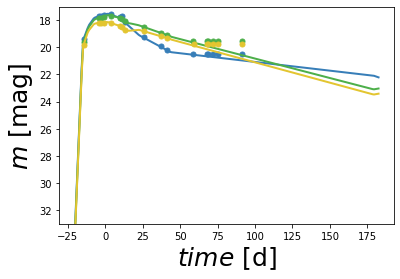

In [22]:
plt.figure()
for i, (f , c) in enumerate(zip(['g','r','i'],['#377eb8','#4daf4a', '#e3c530'])):
    filter_match = np.where(coadd_df['filter'][indexlc]==f)
    mag = obs_template['magobs']['1990N'][0.1][f]
    ph = obs_template['phobs']['1990N'][0.1][f]
    plt.plot(ph, mag,'-',lw=2, color=c)
    plt.plot(np.array(lcEpoch)[filter_match]-20,sim_lc[filter_match],'o',markersize=5, color =c)
    plt.gca().invert_yaxis()
    plt.ylim([33,17])
    plt.xlabel(r'$time$ [d]',fontsize=25)
    plt.ylabel(r'$m$ [mag]',fontsize=25)
    

The we estimated the SNR of the detections in the epochs of the interpolation.

In [23]:
lcSNR = m52snr(sim_lc, coadd_df['fiveSigmaDepth'][indexlc])
np.array(lcSNR)

array([ 1750.4871211 ,  4579.61721286,  8362.7901476 , 16444.85411996,
       12618.90767242,  5845.72859514, 10197.78130805,  5763.93120043,
         807.19498028,   841.06184651,  1199.15727309,   719.76928215,
         355.10243266,   738.57498912,   846.38961397,   501.65634997,
         742.77906707,   778.86453937,  2948.19518232,  3781.59370846,
        5256.25279215,  4743.85873818,  2318.71380179,  2900.40558496,
        1911.07090744,  1158.79001379,  1007.52526465,  1577.37278441,
         637.04677701,   470.27278927,   950.61237952,   998.29465696,
         637.15151026,   839.22071379,  1561.48431817,  6986.42725027,
        6182.51070281, 12340.9971496 , 12863.35651766,  8787.42280997,
        7610.19763599,  5672.28701519,  3169.37239797,  1496.21346622,
        2620.38340532,  1567.25011558,   881.60167225,  1740.12622112,
        1793.35710679,  1381.02714835,  1377.85410741])

Finally we compared the threshold we sat for the detection (SNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5})

In [24]:
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
lcpoints_AboveThresh = np.zeros(len(lcSNR), dtype=bool) 
for f in ['g','r','i']:                    
        filtermatch = np.where(coadd_df['filter'][indexlc] == f)
        lcpoints_AboveThresh[filtermatch] = np.where(np.array(lcSNR)[filtermatch] >= detectSNR[f],True,False) 

In [25]:
lcpoints_AboveThresh

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

We consider two different label for the light curve: detected and classifiable.

- detected: if the number of detection on the lightcurve in all filter is grater than 3;
- classifiable: if the number of detection on the lightcurve in all filter, whitin the 30 days from the explosion, is grater than 5;

Only for those who pass the classifiable threshold we produce a file to inject in PSNID for the classification. 

## PSNID

We finally save the classification results and build a confusion matrix.

It is worth to note that PSNID classify light curves as 'Ia','Ibc','II','UNKNOWN', we considered 'UKNOWN' as the light curve is unclassified.

In [28]:
classify =pd.DataFrame(index=np.arange(0.1,0.9,0.1),columns=['pixId', 'Ia','Ibc','II','UNKNOWN','nDet','nClassified'])
r = subprocess.check_output([os.environ['SNANA_DIR']+'/bin/psnid.exe', os.environ['LSST_DIR']+'/PSNID_LSST_DD.nml'], stderr=subprocess.STDOUT)
# we search for classification flags in the variable r 
Ia=['1990N','1992A','1994D','2002bo','1991T','1999ee','1991bg','2000cx','2002cx']
Ibc=['2009jf','2008D','1994I','2004aw','2007gr','1998bw']
II=['1999em','2004et','2009bw','1999br','1999gi','2005cs','1992H','1993J','2008ax','1987A','2010jl','1998S','1997cy','2005gj','2008es']
                    
                    
classify['Ia'][float(z)]=0
classify['Ibc'][float(z)]=0
classify['II'][float(z)]=0
classify['UNKNOWN'][float(z)]=0
line= np.array(r.split())
custom_split = np.vectorize(snclass.custom_split)
types = np.where(line==b'type')
sn_t = custom_split(x=line[np.where(line==b'Done')[0]+3],c='_',index=0)
sn_Ia= np.in1d(sn_t,Ia)
sn_Ibc= np.in1d(sn_t,Ibc)
sn_II= np.in1d(sn_t,II)

classify['Ia'][float(z)]+=np.sum(line[types[0]+2][sn_Ia]==b'Ia')
classify['Ibc'][float(z)]+=np.sum(line[types[0]+2][sn_Ibc]==b'Ibc')
classify['II'][float(z)]+=np.sum(line[types[0]+2][sn_II]==b'II')
classify['UNKNOWN'][float(z)]+=np.sum(line[types[0]+2]==b'UNKNOWN')

CM = pd.DataFrame(columns= ['Ia','Ibc','II'], index= ['Ia_true','Ibc_true','II_true']).fillna(0)
CM['Ia']['Ia_true']+=np.sum(line[types[0]+2][sn_Ia]==b'Ia')/(np.sum(sn_Ia)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['Ibc']['Ia_true']+=np.sum(line[types[0]+2][sn_Ia]==b'Ibc')/(np.sum(sn_Ia)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['II']['Ia_true']+=np.sum(line[types[0]+2][sn_Ia]==b'II')/(np.sum(sn_Ia)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['Ia']['Ibc_true']+=np.sum(line[types[0]+2][sn_Ibc]==b'Ia')/(np.sum(sn_Ibc)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['Ibc']['Ibc_true']+=np.sum(line[types[0]+2][sn_Ibc]==b'Ibc')/(np.sum(sn_Ibc)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['II']['Ibc_true']+=np.sum(line[types[0]+2][sn_Ibc]==b'II')/(np.sum(sn_Ibc)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['Ia']['II_true']+=np.sum(line[types[0]+2][sn_II]==b'Ia')/(np.sum(sn_II)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['Ibc']['II_true']+=np.sum(line[types[0]+2][sn_II]==b'Ibc')/(np.sum(sn_II)-np.sum(line[types[0]+2]==b'UNKNOWN'))
CM['II']['II_true']+=np.sum(line[types[0]+2][sn_II]==b'II')/(np.sum(sn_II)-np.sum(line[types[0]+2]==b'UNKNOWN'))

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

The confusion matrix is normalized with respect to the the number of classified light curves.

In [29]:
CM

,Ia,Ibc,II
Ia_true,1.0,0.0,0.0
Ibc_true,NaN,NaN,NaN
II_true,NaN,NaN,NaN
